## Import Required Packages

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

import random

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical # pip install git+https://github.com/tensorflow/addons.git
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, TimeDistributed, Dense
from tensorflow_addons.layers import CRF
from tensorflow_addons.optimizers import AdamW
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow_addons.metrics import F1Score

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

2024-12-26 01:47:54.841669: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-26 01:47:54.843667: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-26 01:47:54.869112: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-26 01:47:54.869137: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-26 01:47:54.869165: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

## Define the Problem Statement and perform Exploratory Data Analysis

### Definition of Problem


Implement Named Entity Recognition (NER) for automatic content tagging and analysis. This initiative is intended to overcome the limitations of relying on user-generated hashtags, which can be inconsistent, inaccurate, or absent. The dataset is annotated with 10 fine-grained NER categories: person, geo-location, company, facility, product, music artist, movie, sports team, TV show, and other.

In [2]:
# Check if TensorFlow is built with CUDA support
if tf.test.is_built_with_cuda():
    print("TensorFlow is built with CUDA support.")
else:
    print("TensorFlow is not built with CUDA support.")

# Check if a GPU is available and visible
if tf.config.list_physical_devices('GPU'):
    print("CUDA is available.")
else:
    print("CUDA is not available.")

TensorFlow is built with CUDA support.
CUDA is not available.


2024-12-26 01:47:57.880847: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-12-26 01:47:57.880869: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: varun
2024-12-26 01:47:57.880873: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: varun
2024-12-26 01:47:57.881012: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 550.120.0
2024-12-26 01:47:57.881025: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 550.120.0
2024-12-26 01:47:57.881028: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 550.120.0


In [3]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector
    
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 75
    EMBEDDING = 20

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


## Data Preprocessing

### Data Cleaning and Formatting

In [4]:
def read_conll(file_path):
    sentences = []
    sentence = []

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()

            if line:
                token, tag = line.split('\t')
                sentence.append((token, tag))
            else:
                if sentence:
                    sentences.append(sentence)
                    sentence = []

    return sentences

In [69]:
file_path = "dataset/wnut 16.txt.conll"
data  = read_conll(file_path)
 
data[0]

[('@SammieLynnsMom', 'O'),
 ('@tg10781', 'O'),
 ('they', 'O'),
 ('will', 'O'),
 ('be', 'O'),
 ('all', 'O'),
 ('done', 'O'),
 ('by', 'O'),
 ('Sunday', 'O'),
 ('trust', 'O'),
 ('me', 'O'),
 ('*wink*', 'O')]

In [6]:
len(data)

2393

### Data Transformation for NER

In [7]:
# Convert to a DataFrame if needed
df = pd.DataFrame([(token, tag) for value in data for token, tag in value], columns=['Token', 'Tag'])
print(df.head())

             Token Tag
0  @SammieLynnsMom   O
1         @tg10781   O
2             they   O
3             will   O
4               be   O


### EDA

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46462 entries, 0 to 46461
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Token   46462 non-null  object
 1   Tag     46462 non-null  object
dtypes: object(2)
memory usage: 726.1+ KB


In [9]:
df.shape

(46462, 2)

In [10]:
print("Number of sentences: ", len(data))

Number of sentences:  2393


In [11]:
print("Number of labels", df["Tag"].nunique())

Number of labels 21


In [12]:
print("Frequency of labels", df["Tag"].value_counts())

Frequency of labels Tag
O                44000
B-person           449
I-other            320
B-geo-loc          276
B-other            225
I-person           215
B-company          171
I-facility         105
B-facility         104
B-product           97
I-product           80
I-musicartist       61
B-musicartist       55
B-sportsteam        51
I-geo-loc           49
I-movie             46
I-company           36
B-movie             34
B-tvshow            34
I-tvshow            31
I-sportsteam        23
Name: count, dtype: int64


In [13]:
senteces_length = [len(s) for s in data]

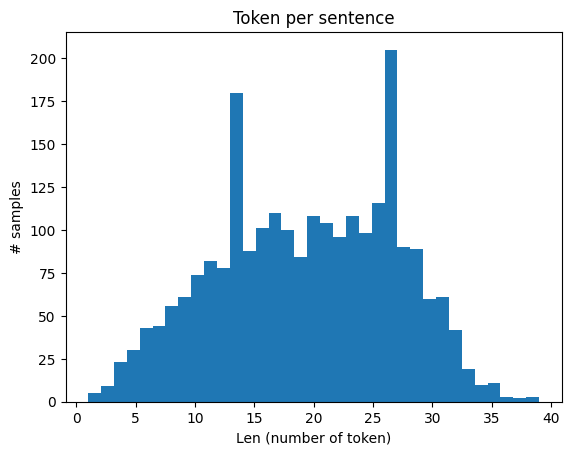

In [14]:
# Plot sentence by lenght
plt.hist(senteces_length, bins=35)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

From the histogram, we can see most of the sentences have around <b> 15 to 30 tokens </b>. Tokens can we referred as words ignoring punctuation marks.

<Axes: >

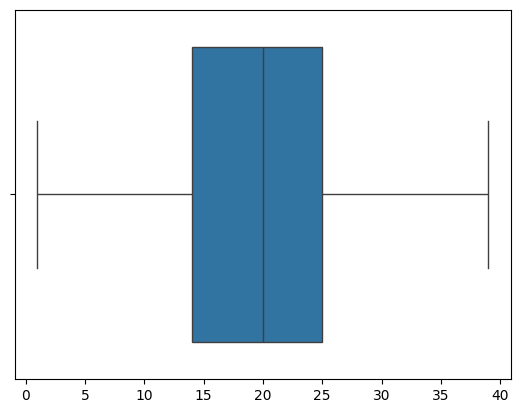

In [15]:
sns.boxplot(x = senteces_length)

### Handling Sparse Data

In [16]:
df.head()

,Token,Tag
0,@SammieLynnsMom,O
1,@tg10781,O
2,they,O
3,will,O
4,be,O


In [17]:
df.Tag.value_counts()

Tag
O                44000
B-person           449
I-other            320
B-geo-loc          276
B-other            225
I-person           215
B-company          171
I-facility         105
B-facility         104
B-product           97
I-product           80
I-musicartist       61
B-musicartist       55
B-sportsteam        51
I-geo-loc           49
I-movie             46
I-company           36
B-movie             34
B-tvshow            34
I-tvshow            31
I-sportsteam        23
Name: count, dtype: int64

In [18]:
df["entity"] = df["Tag"].apply(lambda x : x.split("-")[-1] if len(x.split("-")) > 1 else "")

In [19]:
df.entity.value_counts()

entity
               44000
person           664
other            545
loc              325
facility         209
company          207
product          177
musicartist      116
movie             80
sportsteam        74
tvshow            65
Name: count, dtype: int64

In [20]:
lowcount_labels = df.entity.value_counts().iloc[3:].reset_index().entity.tolist()

In [21]:
for ele in data[:5]:
    print(ele)

[('@SammieLynnsMom', 'O'), ('@tg10781', 'O'), ('they', 'O'), ('will', 'O'), ('be', 'O'), ('all', 'O'), ('done', 'O'), ('by', 'O'), ('Sunday', 'O'), ('trust', 'O'), ('me', 'O'), ('*wink*', 'O')]
[('Made', 'O'), ('it', 'O'), ('back', 'O'), ('home', 'O'), ('to', 'O'), ('GA', 'B-geo-loc'), ('.', 'O'), ('It', 'O'), ('sucks', 'O'), ('not', 'O'), ('to', 'O'), ('be', 'O'), ('at', 'O'), ('Disney', 'B-facility'), ('world', 'I-facility'), (',', 'O'), ('but', 'O'), ('its', 'O'), ('good', 'O'), ('to', 'O'), ('be', 'O'), ('home', 'O'), ('.', 'O'), ('Time', 'O'), ('to', 'O'), ('start', 'O'), ('planning', 'O'), ('the', 'O'), ('next', 'O'), ('Disney', 'B-facility'), ('World', 'I-facility'), ('trip', 'O'), ('.', 'O')]
[("'", 'O'), ('Breaking', 'B-movie'), ('Dawn', 'I-movie'), ("'", 'O'), ('Returns', 'O'), ('to', 'O'), ('Vancouver', 'B-geo-loc'), ('on', 'O'), ('January', 'O'), ('11th', 'O'), ('http://bit.ly/dbDMs8', 'O')]
[('@ls_n', 'O'), ('perhaps', 'O'), (',', 'O'), ('but', 'O'), ('folks', 'O'), ('may'

### Oversampling

In [22]:
# oversampled_data = data

In [23]:
oversampling = {}
for label in lowcount_labels:
    oversampling[label] = []
for sentence in data:
    for word, label in sentence:
        if label.split("-")[-1] in df.entity.value_counts().iloc[3:].reset_index().entity.tolist():
            oversampling[label.split("-")[-1]].append(sentence)
            break

In [24]:
for key, value in oversampling.items():
    print(key, len(value))

loc 174
facility 77
company 135
product 65
musicartist 35
movie 24
sportsteam 37
tvshow 29


In [25]:
len(data)

2393

In [26]:
oversampled_data = data + random.choices(oversampling["loc"], k=200)
oversampled_data += random.choices(oversampling["facility"], k=300)
oversampled_data += random.choices(oversampling["company"], k=300)
oversampled_data += random.choices(oversampling["product"], k=400)
oversampled_data += random.choices(oversampling["musicartist"], k=400)
oversampled_data += random.choices(oversampling["movie"], k=500)
oversampled_data += random.choices(oversampling["sportsteam"], k=500)
oversampled_data += random.choices(oversampling["tvshow"], k=500)

In [27]:
len(oversampled_data)

5493

### Tokenization and Encoding:

In [28]:
df.head()

,Token,Tag,entity
0,@SammieLynnsMom,O,
1,@tg10781,O,
2,they,O,
3,will,O,
4,be,O,


In [29]:
df["Token"].value_counts()

Token
.               1524
,                914
the              876
to               824
I                762
                ... 
shaped             1
hole               1
Def                1
tune               1
@ihatequotes       1
Name: count, Length: 10585, dtype: int64

In [30]:
words = list(set(df["Token"].values))
print("Number of unique words in the dataset: ", len(words))

Number of unique words in the dataset:  10585


In [31]:
df["Tag"].value_counts()

Tag
O                44000
B-person           449
I-other            320
B-geo-loc          276
B-other            225
I-person           215
B-company          171
I-facility         105
B-facility         104
B-product           97
I-product           80
I-musicartist       61
B-musicartist       55
B-sportsteam        51
I-geo-loc           49
I-movie             46
I-company           36
B-movie             34
B-tvshow            34
I-tvshow            31
I-sportsteam        23
Name: count, dtype: int64

In [32]:
tags = list(set(df["Tag"].values))
print("Number of Labels: ", len(tags))

Number of Labels:  21


In [33]:
tags

['I-other',
 'B-product',
 'B-person',
 'I-sportsteam',
 'B-company',
 'I-tvshow',
 'O',
 'I-product',
 'B-other',
 'I-movie',
 'B-geo-loc',
 'B-sportsteam',
 'B-movie',
 'I-facility',
 'I-person',
 'I-musicartist',
 'I-geo-loc',
 'B-facility',
 'B-tvshow',
 'B-musicartist',
 'I-company']

### Indexing my words and labels to consider them as Tokens

In [34]:
word2idx = {w:i+2 for i,w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0

tag2idx = {t:i+2 for i,t in enumerate(tags)}
tag2idx["PAD"] = 0
tag2idx["UNK"] = 1

print("The word doctor is identified by the index: {}".format(word2idx["doctor"]))
print("The labels B-movie(which defines Movie Enitities at the Bengining) is identified by the index: {}".format(tag2idx["B-movie"]))

The word doctor is identified by the index: 5985
The labels B-movie(which defines Movie Enitities at the Bengining) is identified by the index: 14


In [35]:
tag2idx

{'I-other': 2,
 'B-product': 3,
 'B-person': 4,
 'I-sportsteam': 5,
 'B-company': 6,
 'I-tvshow': 7,
 'O': 8,
 'I-product': 9,
 'B-other': 10,
 'I-movie': 11,
 'B-geo-loc': 12,
 'B-sportsteam': 13,
 'B-movie': 14,
 'I-facility': 15,
 'I-person': 16,
 'I-musicartist': 17,
 'I-geo-loc': 18,
 'B-facility': 19,
 'B-tvshow': 20,
 'B-musicartist': 21,
 'I-company': 22,
 'PAD': 0,
 'UNK': 1}

### Training: Data Creation

In [36]:
oversampled_data[0]

[('@SammieLynnsMom', 'O'),
 ('@tg10781', 'O'),
 ('they', 'O'),
 ('will', 'O'),
 ('be', 'O'),
 ('all', 'O'),
 ('done', 'O'),
 ('by', 'O'),
 ('Sunday', 'O'),
 ('trust', 'O'),
 ('me', 'O'),
 ('*wink*', 'O')]

In [37]:
X = [[word2idx[ele[0]] for ele in sentence] for sentence in oversampled_data]

# pad the sequences, to have same length
X = pad_sequences(
    maxlen = MAX_LEN,
    sequences = X,
    padding = "post",
    value = word2idx["PAD"]
)

print('Raw Sample:\n ', ' '.join([w[0] for w in oversampled_data[0]]))
print('\n ' )
print('After processing, sample:\n', X[0])

Raw Sample:
  @SammieLynnsMom @tg10781 they will be all done by Sunday trust me *wink*

 
After processing, sample:
 [2141 1492 7378 7772  358 1763 6896 7603 3645 2926 9552 7791    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]


In [38]:
# Convert my Tag/Label to tag_index
y = [[tag2idx[ele[1]] for ele in sentence] for sentence in oversampled_data]

# Padding each label to have same length
y = pad_sequences(
    maxlen = MAX_LEN,
    sequences = y,
    padding = "post",
    value = tag2idx["PAD"]
)

print('Raw Label:\n ', ' '.join([w[1] for w in oversampled_data[0]]))
print('\n ' )
print('After processing, labels:\n', y[0])

Raw Label:
  O O O O O O O O O O O O

 
After processing, labels:
 [8 8 8 8 8 8 8 8 8 8 8 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]


In [39]:
# One-Hot encode
y = [to_categorical(i, num_classes=23) for i in y]  # n_tags+1(PAD)

from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

y_tr = np.array(y_tr)
y_te = np.array(y_te)

In [40]:
len(X_tr), len(y_tr)

(4943, 4943)

In [41]:
X_tr[0]

array([3055, 6858, 8948, 4280, 6579, 6870, 4294, 2474, 3323, 6645,  358,
       7048, 9704,  827, 2498, 6995, 2838, 1296, 2581, 1670, 5863, 6367,
       1509, 8476, 6546,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [42]:
y_tr[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Model Building - Bi-LSTM + CRF

### Training LSTM + CRF Models with Embeddings

In [43]:
def build_model(max_len=75, input_dim=len(words)+2, embedding_dim=200): # 10585 vocab size
    # Model definition
    input_layer = Input(shape=(max_len,), name='input_layer')

    # Embedding layer
    embeddings = Embedding(
        input_dim=input_dim,
        output_dim=embedding_dim,
        input_length=max_len,
        mask_zero=True
    )(input_layer)

    # BiLSTM layers
    lstm_output = Bidirectional(LSTM(units=50, return_sequences=True))(embeddings)
    lstm_output = Bidirectional(LSTM(units=50, return_sequences=True))(lstm_output)

    # # Dense layer
    dense_output = TimeDistributed(Dense(23, activation="relu"))(lstm_output)

    # CRF layer
    crf = CRF(23, name='crf')  # 21 classes
    predicted_sequence, potentials, sequence_length, crf_kernel = crf(dense_output)

    # Build the model
    model = Model(inputs=input_layer, outputs=potentials, name = "Twitter_NER_V1")

    # Compile the model
    model.compile(
        optimizer=AdamW(weight_decay=0.001 ,learning_rate=0.001),
        loss=SigmoidFocalCrossEntropy(),  # Use CRF-specific loss
        # loss = custom_loss,
        metrics=["accuracy"]   # Optional: Use CRF accuracy
    )

    return model

# Build and compile the model
model = build_model()

# Checkpointing
save_model = tf.keras.callbacks.ModelCheckpoint(filepath='twitter_ner_crf.weights.h5',
  monitor='val_loss',
  save_weights_only=True,
  save_best_only=True,
  verbose=1
)

# Early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=10)

callbacks = [save_model, es]

model.summary()

Model: "Twitter_NER_V1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 75)]              0         
                                                                 
 embedding (Embedding)       (None, 75, 200)           2117400   
                                                                 
 bidirectional (Bidirection  (None, 75, 100)           100400    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 75, 100)           60400     
 onal)                                                           
                                                                 
 time_distributed (TimeDist  (None, 75, 23)            2323      
 ributed)                                                        
                                                    

### Model Training

In [44]:
model.fit(
    X_tr, y_tr, 
    validation_data = (X_te, y_te),
    batch_size=BATCH_SIZE,
    epochs=100, 
    shuffle = True)

Epoch 1/100
155/155 [==============================] - 17s 62ms/step - loss: 0.6949 - accuracy: 0.6348 - val_loss: 0.4661 - val_accuracy: 0.2348
Epoch 2/100
155/155 [==============================] - 7s 45ms/step - loss: 0.3708 - accuracy: 0.9653 - val_loss: 0.2962 - val_accuracy: 0.9695
Epoch 3/100
155/155 [==============================] - 7s 44ms/step - loss: 0.2419 - accuracy: 0.9702 - val_loss: 0.2019 - val_accuracy: 0.9697
Epoch 4/100
155/155 [==============================] - 7s 45ms/step - loss: 0.1693 - accuracy: 0.9715 - val_loss: 0.1498 - val_accuracy: 0.9701
Epoch 5/100
155/155 [==============================] - 7s 45ms/step - loss: 0.1258 - accuracy: 0.9766 - val_loss: 0.1175 - val_accuracy: 0.9789
Epoch 6/100
155/155 [==============================] - 7s 43ms/step - loss: 0.0990 - accuracy: 0.9833 - val_loss: 0.0968 - val_accuracy: 0.9845
Epoch 7/100
155/155 [==============================] - 7s 44ms/step - loss: 0.0824 - accuracy: 0.9875 - val_loss: 0.0862 - val_accuracy

### Validation Data Evaluation

In [45]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# Flatten the sequences and exclude padding tokens
def filter_padding(y_pred, y_true, pad_token=0):
    filtered_pred = []
    filtered_true = []
    for pred_seq, true_seq in zip(y_pred, y_true):
        for pred_label, true_label in zip(pred_seq, true_seq):
            if true_label != pad_token and pred_label != pad_token and true_label != 21 and pred_label != 21:  # Ignore padding tokens
                filtered_pred.append(pred_label)
                filtered_true.append(true_label)
    return np.array(filtered_pred), np.array(filtered_true)

In [46]:
# Predict probabilities
y_val_pred_prob = model.predict(X_te)

18/18 [==============================] - 3s 11ms/step


In [47]:
y_val_pred = np.argmax(y_val_pred_prob, axis=2)
np.argmax(y_te, axis=2)[0]

array([ 8,  8,  8,  8,  8,  8,  8, 21, 17,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0])

In [48]:
# Convert predictions and true labels, ignoring padding tokens
y_pred_flat, y_true_flat = filter_padding(y_val_pred, np.argmax(y_te, axis=2))

# Calculate metrics
accuracy = accuracy_score(y_true_flat, y_pred_flat)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9915254237288136


In [49]:
# Classification report
print("Classification Report:")
print(classification_report(y_true_flat, y_pred_flat))

Classification Report:
              precision    recall  f1-score   support

           2       0.97      0.80      0.88        79
           3       1.00      1.00      1.00        55
           4       0.97      0.81      0.88       143
           5       0.95      1.00      0.97        39
           6       0.91      0.85      0.88        61
           7       0.98      1.00      0.99        42
           8       0.99      1.00      1.00      9665
           9       1.00      1.00      1.00        64
          10       0.95      0.77      0.85        53
          11       0.99      1.00      1.00       105
          12       0.98      0.99      0.98        81
          13       0.99      1.00      0.99        73
          14       0.99      1.00      0.99        77
          15       0.98      1.00      0.99        49
          16       0.95      0.93      0.94        68
          17       1.00      1.00      1.00        74
          18       1.00      1.00      1.00        18
    

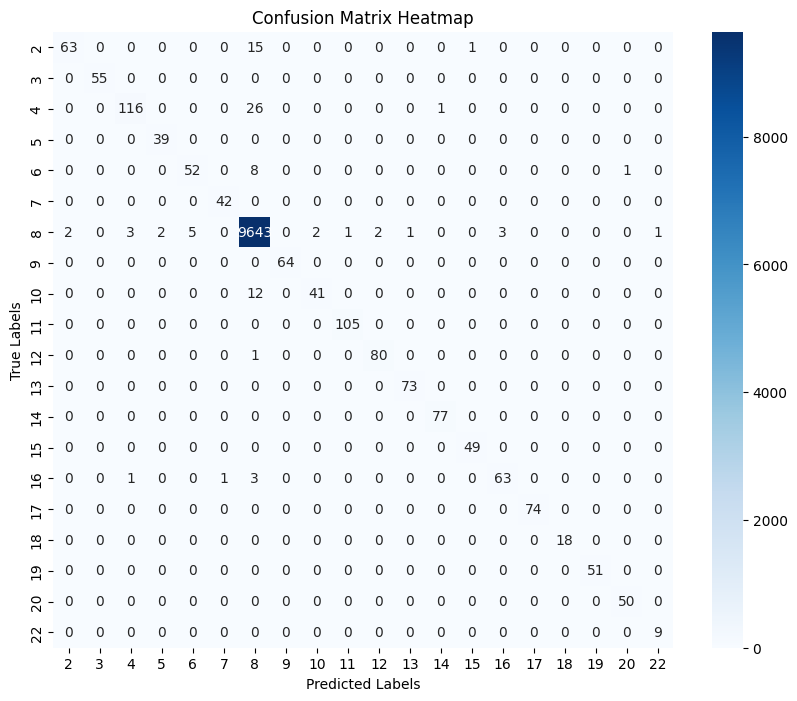

In [50]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true_flat), yticklabels=np.unique(y_true_flat))

# Labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [51]:
tag2idx

{'I-other': 2,
 'B-product': 3,
 'B-person': 4,
 'I-sportsteam': 5,
 'B-company': 6,
 'I-tvshow': 7,
 'O': 8,
 'I-product': 9,
 'B-other': 10,
 'I-movie': 11,
 'B-geo-loc': 12,
 'B-sportsteam': 13,
 'B-movie': 14,
 'I-facility': 15,
 'I-person': 16,
 'I-musicartist': 17,
 'I-geo-loc': 18,
 'B-facility': 19,
 'B-tvshow': 20,
 'B-musicartist': 21,
 'I-company': 22,
 'PAD': 0,
 'UNK': 1}

### Testing: Dataset creation

In [52]:
file_path = "dataset/wnut 16test.txt.conll"
test_data  = read_conll(file_path)

In [53]:
len(test_data)

3849

In [54]:
print(test_data[0])

[('New', 'B-other'), ('Orleans', 'I-other'), ('Mother', 'I-other'), ("'s", 'I-other'), ('Day', 'I-other'), ('Parade', 'I-other'), ('shooting', 'O'), ('.', 'O'), ('One', 'O'), ('of', 'O'), ('the', 'O'), ('people', 'O'), ('hurt', 'O'), ('was', 'O'), ('a', 'O'), ('10-year-old', 'O'), ('girl', 'O'), ('.', 'O'), ('WHAT', 'O'), ('THE', 'O'), ('HELL', 'O'), ('IS', 'O'), ('WRONG', 'O'), ('WITH', 'O'), ('PEOPLE', 'O'), ('?', 'O')]


In [55]:
# Convert to a DataFrame if needed
test_df = pd.DataFrame([(token, tag) for value in test_data for token, tag in value], columns=['Token', 'Tag'])
print(test_df.head())

     Token      Tag
0      New  B-other
1  Orleans  I-other
2   Mother  I-other
3       's  I-other
4      Day  I-other


In [56]:
test_df["Tag"].value_counts(), len(test_df["Tag"].value_counts())

(Tag
 O                55941
 B-geo-loc          882
 B-company          621
 B-other            584
 I-other            556
 I-product          500
 B-person           482
 I-facility         366
 I-person           300
 I-company          265
 B-facility         253
 B-product          246
 I-geo-loc          219
 B-musicartist      191
 B-sportsteam       147
 I-musicartist      140
 I-movie             48
 I-sportsteam        48
 I-tvshow            40
 B-movie             34
 B-tvshow            33
 Name: count, dtype: int64,
 21)

In [57]:
df["Tag"].value_counts(), len(df["Tag"].value_counts())

(Tag
 O                44000
 B-person           449
 I-other            320
 B-geo-loc          276
 B-other            225
 I-person           215
 B-company          171
 I-facility         105
 B-facility         104
 B-product           97
 I-product           80
 I-musicartist       61
 B-musicartist       55
 B-sportsteam        51
 I-geo-loc           49
 I-movie             46
 I-company           36
 B-movie             34
 B-tvshow            34
 I-tvshow            31
 I-sportsteam        23
 Name: count, dtype: int64,
 21)

In [58]:
X_test = [[word2idx.get(ele[0], word2idx["UNK"]) for ele in sentence] for sentence in test_data]

# pad the sequences, to have same length
X_test = pad_sequences(
    maxlen = MAX_LEN,
    sequences = X_test,
    padding = "post",
    value = word2idx["PAD"]
)

# Convert my Tag/Label to tag_index
y_test = [[tag2idx.get(ele[1], tag2idx["UNK"]) for ele in sentence] for sentence in test_data]

# Padding each label to have same length
y_test = pad_sequences(
    maxlen = MAX_LEN,
    sequences = y_test,
    padding = "post",
    value = tag2idx["PAD"]
)

print(test_data[0])
print("Testing Sample input", X_test[0])
print("Testing Label", y_test[0])

[('New', 'B-other'), ('Orleans', 'I-other'), ('Mother', 'I-other'), ("'s", 'I-other'), ('Day', 'I-other'), ('Parade', 'I-other'), ('shooting', 'O'), ('.', 'O'), ('One', 'O'), ('of', 'O'), ('the', 'O'), ('people', 'O'), ('hurt', 'O'), ('was', 'O'), ('a', 'O'), ('10-year-old', 'O'), ('girl', 'O'), ('.', 'O'), ('WHAT', 'O'), ('THE', 'O'), ('HELL', 'O'), ('IS', 'O'), ('WRONG', 'O'), ('WITH', 'O'), ('PEOPLE', 'O'), ('?', 'O')]
Testing Sample input [ 5890     1     1 10446   365  3828  1843  6293   988  9423  6870  4062
  1627  6080  1063     1   875  6293  7175  3467     1  8327     1  2901
     1  1304     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
Testing Label [10  2  2  2  2  2  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  

In [59]:
# Predict probabilities
y_test_pred_prob = model.predict(X_test)

121/121 [==============================] - 1s 11ms/step


In [60]:
y_test_pred_prob[0], len(y_test_pred_prob[0]), y_test_pred_prob.shape

(array([[-6.4168948e-01, -2.3866366e-07, -6.2580949e-01, ...,
         -4.0050995e-01, -6.1913210e-01, -5.6546384e-01],
        [-6.1501372e-01, -1.9758555e-07, -1.2933204e-01, ...,
         -5.7803184e-01, -1.1155785e+00, -2.6052138e-01],
        [-7.6067221e-01, -2.0948272e-07, -1.1059452e-01, ...,
         -5.7396168e-01, -1.1432058e+00, -3.6791816e-01],
        ...,
        [ 9.3481624e-01, -2.6870424e-08,  2.1078340e-03, ...,
         -5.1003680e-02, -4.7046971e-03, -5.0144196e-03],
        [ 9.3481624e-01, -2.6870424e-08,  2.1078340e-03, ...,
         -5.1003680e-02, -4.7046971e-03, -5.0144196e-03],
        [ 9.3481624e-01, -2.6870424e-08,  2.1078340e-03, ...,
         -5.1003680e-02, -4.7046971e-03, -5.0144196e-03]], dtype=float32),
 75,
 (3849, 75, 23))

In [61]:
# # Convert probabilities to class predictions (for multi-class classification)
y_val_pred = np.argmax(y_test_pred_prob, axis=2)

In [62]:
y_val_pred[0], len(y_val_pred[0]), y_test[0], len(y_test[0])

(array([12,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0]),
 75,
 array([10,  2,  2,  2,  2,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0], dtype=int32),
 75)

In [63]:
y_val_pred[1], len(y_val_pred[1]), y_test[1], len(y_test[1])

(array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0]),
 75,
 array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 75)

In [64]:
# Convert predictions and true labels, ignoring padding tokens
y_pred_flat, y_true_flat = filter_padding(y_val_pred, y_test)

# Calculate metrics
accuracy = accuracy_score(y_true_flat, y_pred_flat)
print(f"Accuracy: {accuracy}")


Accuracy: 0.9078221301594309


In [65]:
# Classification report
print("Classification Report:")
print(classification_report(y_true_flat, y_pred_flat))

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.25      0.11      0.15       540
           3       0.19      0.05      0.08       229
           4       0.37      0.17      0.24       459
           5       0.15      0.04      0.07        46
           6       0.59      0.12      0.20       534
           7       0.00      0.00      0.00        40
           8       0.92      0.99      0.96     53465
           9       0.29      0.01      0.02       469
          10       0.17      0.05      0.08       551
          11       0.00      0.00      0.00        47
          12       0.60      0.23      0.34       836
          13       0.21      0.04      0.07       143
          14       0.00      0.00      0.00        31
          15       0.43      0.12      0.19       357
          16       0.23      0.06      0.09       287
          17       0.14      0.01      0.03       134
    

/home/varun/Documents/MS/Business Cases/Twitter NER NLP/.twitter_venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/varun/Documents/MS/Business Cases/Twitter NER NLP/.twitter_venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/varun/Documents/MS/Business Cases/Twitter NER NLP/.twitter_venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` param

In [66]:
np.unique(y_true_flat)

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 22], dtype=int32)

In [67]:
np.unique(y_pred_flat)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 22])

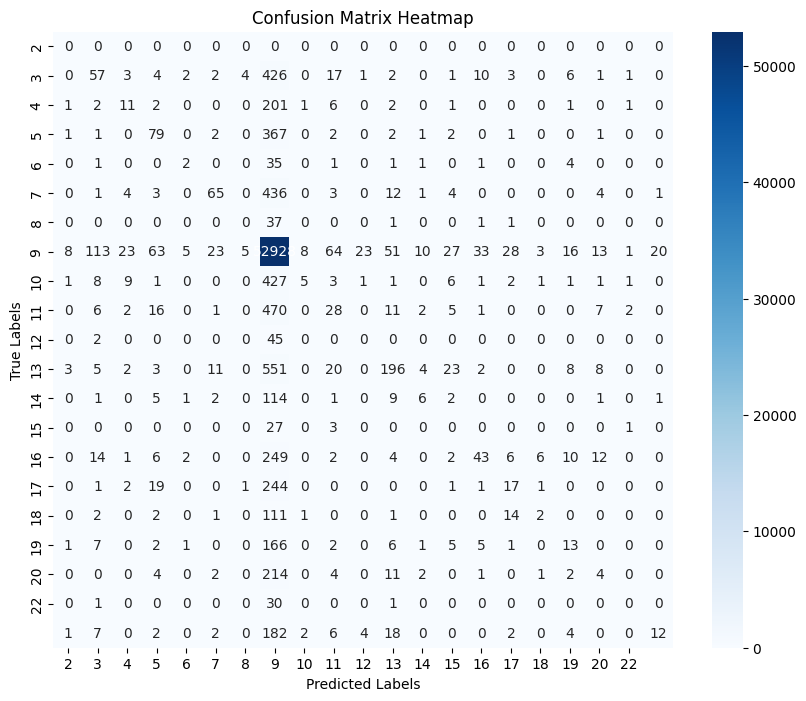

In [68]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Flatten the sequences and exclude padding tokens (filter padding as before)
y_pred_flat, y_true_flat = filter_padding(y_val_pred, y_test)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true_flat), yticklabels=np.unique(y_true_flat))

# Labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()